# Tratamiento de imágenes - 2023 - Entregable 2

# Fecha de entrega: 5/5/2023

### Importante:   
En todos los ejercicios se espera que se entregue comentarios sobre decisiones tomadas en la implementación así como un análisis de los resultados. Estos comentarios y análisis se pueden entregar en celdas de texto agregadas a los notebooks o en un informe aparte.

Para la entrega se sube un **zip** (no rar, ni otro formato) con:
* El notebook del entregable modificado. El notebook debe tener las celdas ejecutadas con las salidas correspondientes. Debe tener todo lo necesario para poder ser ejecutado nuevamente
* Todo el resto del contenido del zip del entregable. Si, para mostrar resultados, usan en el notebook imágenes propias, deben incluirlas en la carpeta **imagenes**  del zip. 
* El informe en pdf en caso de no incluir las discusiones dentro del notebook en celdas "Markdown", o si les resulta más sencillo realizar el análisis en un documento aparte.

No se deben incluir en el zip de la entrega las imágenes de prueba que están disponibles en la página web del curso. Se asumirá que esas imágenes están en un directorio y se hará referencia a dichas imágenes en forma relativa a ese directorio (ver la celda siguiente).

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# FORMAS DE VER LAS GRAFICAS --------------------
# ELEGIR UNA DE LAS OPCIONES Y DES-COMENTAR (sacar # de la linea)
# ----------------
# a) graficas en línea  entre las celdas (no interactivo)
%matplotlib inline
# ---------------- 
# b) graficas en línea  entre las celdas (interactivo)
# %matplotlib notebook
# ----------------
# c) graficas en ventanas externas (abre una ventana por cada figura)
#%matplotlib
# ----------------
# d) Si se usa "jupyter lab" en lugar de "jupyter notebook" usar %matplotlib widget en lugar de %matplotlib notebook 
# requiere instalar el modulo "ipympl". Ver https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab#56416229
# %matplotlib widget
#---------------------------------------------------



# Directorio con la base de imágenes de prueba (las que están en la web de Timag)
# Ej. si usan la imagen trapo.jpg en el notebook no tienen que subirla al eva
# La llaman en el notebook en forma relativa a donde tengan esas imagenes:
# 
# filename = os.path.join(dir_base_imagenes, 'trapo.jpg')
# I = imread(filename)
dir_base_imagenes = 'base_imagenes'


# Directorio con la base de imágenes de documentos (para el ejercicio 5)
# En el notebook acceden a esos datos en forma relativa a donde tengan esas imagenes:
# 
# filename = os.path.join(dir_base_documentos, '0012183661.tif')
# I = imread(filename)
dir_base_documentos = 'base_documentos'


## Transformaciones geométricas

### 1. Implementar una función que realice transformaciones proyectivas

In [2]:
def bilineal(I, punto, color_de_fondo):
    """
    Dado un punto de coordenadas no necesariamente enteras y una imagen I, 
    retorna la interpolación bilineal entre los cuatro pixeles de I más cercanos
    al punto de entrada.
    
    Args:
    - I (array 2D): Imagen de referencia para interpolar.
    - punto (tuple/list): coordenadas en imagen en formato: punto = (fila,columna) ó punto = [fila,columna]
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.
    
    Returns:
    valor_interpolado (int): valor interpolado en escala de grises para el punto. 
    """
    #implementar
    y, x = punto
    altura, anchura = I.shape[0:2]
    
    # Índices enteros de los pixeles vecinos
    x1 = int(np.floor(x))
    x2 = x1 + 1
    y1 = int(np.floor(y))
    y2 = y1 + 1

    # Verificar si el punto está dentro de los límites de la imagen
    if y1 < 0 or y2 >= anchura or x1 < 0 or x2 >= altura:
        return color_de_fondo
    
    # Ponderación de los pixeles vecinos
    w_x1 = x2 - x
    w_x2 = x - x1
    w_y1 = y2 - y
    w_y2 = y - y1

    # Interpolación bilineal
    pixel_1 = I[y1, x1] * w_x1 + I[y1, x2] * w_x2
    pixel_2 = I[y2, x1] * w_x1 + I[y2, x2] * w_x2
    valor_interpolado = pixel_1 * w_y1 + pixel_2 * w_y2

    return valor_interpolado

def vecino(img, punto, color_de_fondo):
    """
    Dado un punto de coordenadas no necesariamente enteras y una imagen I, 
    retorna el nivel de gris correspondiente al pixel más cercano I.
    
    Args:
    - img (array 2D): Imagen de referencia para interpolar.
    - punto (tuple/list): coordenadas en imagen en formato: punto = (fila,columna) ó punto = [fila,columna]
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.
    
    Returns:
    valor_interpolado (int): valor interpolado en escala de grises para el punto. 
    """

    #implementar
    fila, columna = round(punto[0]), round(punto[1])

    if fila >= 0 and fila < img.shape[0] and columna >= 0 and columna < img.shape[1]:
        valor_interpolado = img[fila, columna]
    else:
        valor_interpolado = color_de_fondo
    return valor_interpolado

def transformar(I, T, tipo_interpolacion='vecino', color_de_fondo=0):
    """
    Aplicar una transformacion geometrica T a imagen I, especificando el tipo de interpolacion.
    
    Args:
    - I (array 2D): imagen a transformar.
    - T (array 2D): matriz de transformacion de tamaño 3x3.
    - tipo_interpolacion (str): interpolación a utilizar: 'vecino' más cercano (default) o 'bilineal'.
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.
    
    Returns:
    I_transformada (array 2D): imagen transformada
    
    """
    #implementar
    # Obtener dimensiones de la imagen
    alto, ancho = I.shape

    # Crear una imagen vacía con las mismas dimensiones que la imagen de entrada
    I_transformada = np.zeros((alto, ancho), dtype=I.dtype)

    # Invertir la matriz de transformación
    T_inv = np.linalg.inv(T)

    # Iterar a través de cada píxel en la imagen transformada
    for y in range(alto):
        for x in range(ancho):
            # Encontrar las coordenadas correspondientes en la imagen de entrada
            coords = np.dot(T_inv, np.array([x, y, 1]))
            x_orig, y_orig = coords[0:2] / coords[2]

            # Verificar si las coordenadas están dentro de las dimensiones de la imagen de entrada
            if 0 <= x_orig < ancho and 0 <= y_orig < alto:
                # Aplicar la interpolación especificada
                if tipo_interpolacion == 'bilineal':
                    I_transformada[y, x] = bilineal(I, [y_orig, x_orig], color_de_fondo)
                else:
                    I_transformada[y, x] = vecino(I, [y_orig, x_orig], color_de_fondo)
            else:
                # Asignar el color de fondo si las coordenadas están fuera de las dimensiones de la imagen de entrada
                I_transformada[y, x] = color_de_fondo

    return I_transformada

### 2. Usando la función transformar, mostrar ejemplos de transformaciones isométricas, afines y proyectivas  con diferentes interpolaciones

Parecido a lo que se muestra en estos ejemplos de scikit-image:  
https://scikit-image.org/docs/stable/auto_examples/transform/plot_transform_types.html


#### Mostrar una rotación con origen en vértice superior izquierdo de la imagen (origen de coordenadas) 

(-0.5, 255.5, 255.5, -0.5)

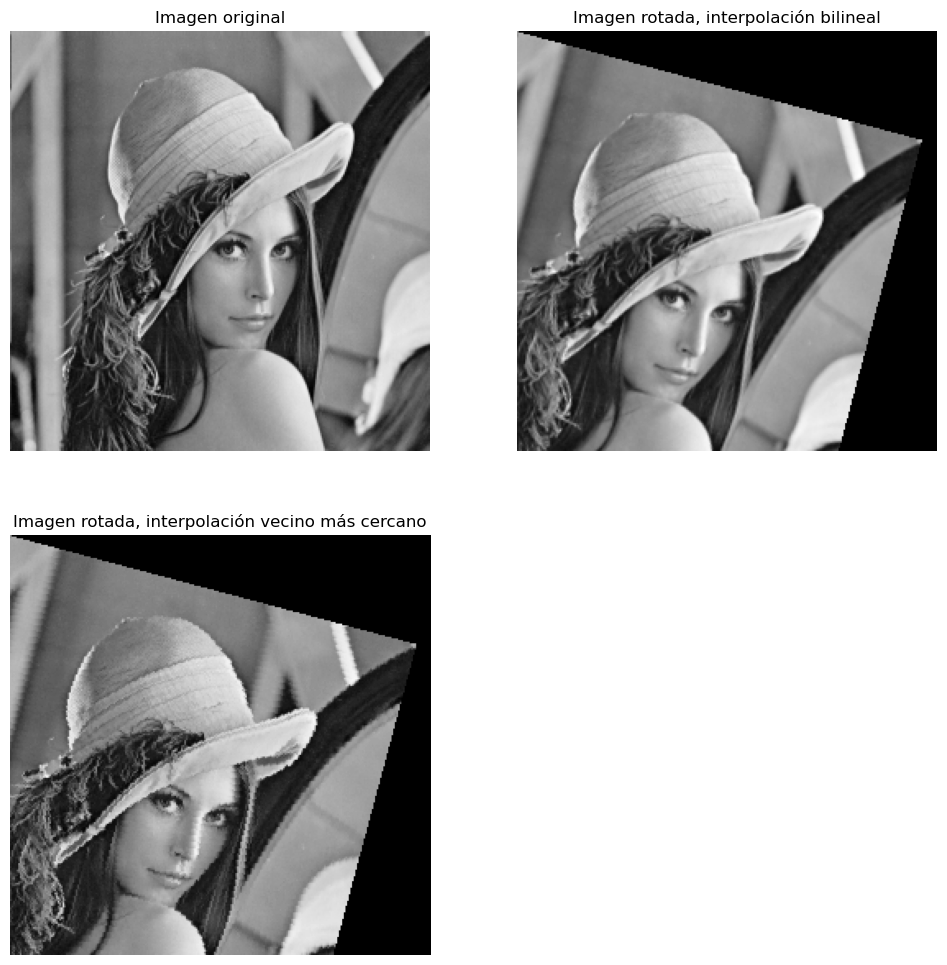

In [3]:
I=imread(dir_base_imagenes+'\lena.bmp')

def matriz_rotacion(angulo_grados):
    angulo_rad=np.radians(angulo_grados)
    return np.array([
        [np.cos(angulo_rad), -np.sin(angulo_rad), 0],
        [np.sin(angulo_rad),  np.cos(angulo_rad), 0],
        [0, 0, 1]
    ])


# Calcular la matriz de transformación de rotación
T_rotacion = matriz_rotacion(15)

# Aplicar la transformación de rotación a la imagen
imagen_rotada_1 = transformar(I, T_rotacion, 'bilineal')
imagen_rotada_2 = transformar(I, T_rotacion, 'vecino')

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(I, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(imagen_rotada_1, cmap='gray')
plt.title('Imagen rotada, interpolación bilineal')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(imagen_rotada_2, cmap='gray')
plt.title('Imagen rotada, interpolación vecino más cercano')
plt.axis('off')

#### Mostrar una rotación con origen en el centro de la imagen
La transformación de rotación en el centro de la imagen puede calcularse como la composición de una traslación, una rotación y una traslación.  

Matriz de traslación al origen:
[[   1.    0. -128.]
 [   0.    1. -128.]
 [   0.    0.    1.]]
Matriz de rotación:
[[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]
Matriz de traslación de vuelta al centro:
[[  1.   0. 128.]
 [  0.   1. 128.]
 [  0.   0.   1.]]
Matriz de transformación compuesta:
[[  0.8660254   -0.5         81.14874832]
 [  0.5          0.8660254  -46.85125168]
 [  0.           0.           1.        ]]


(-0.5, 255.5, 255.5, -0.5)

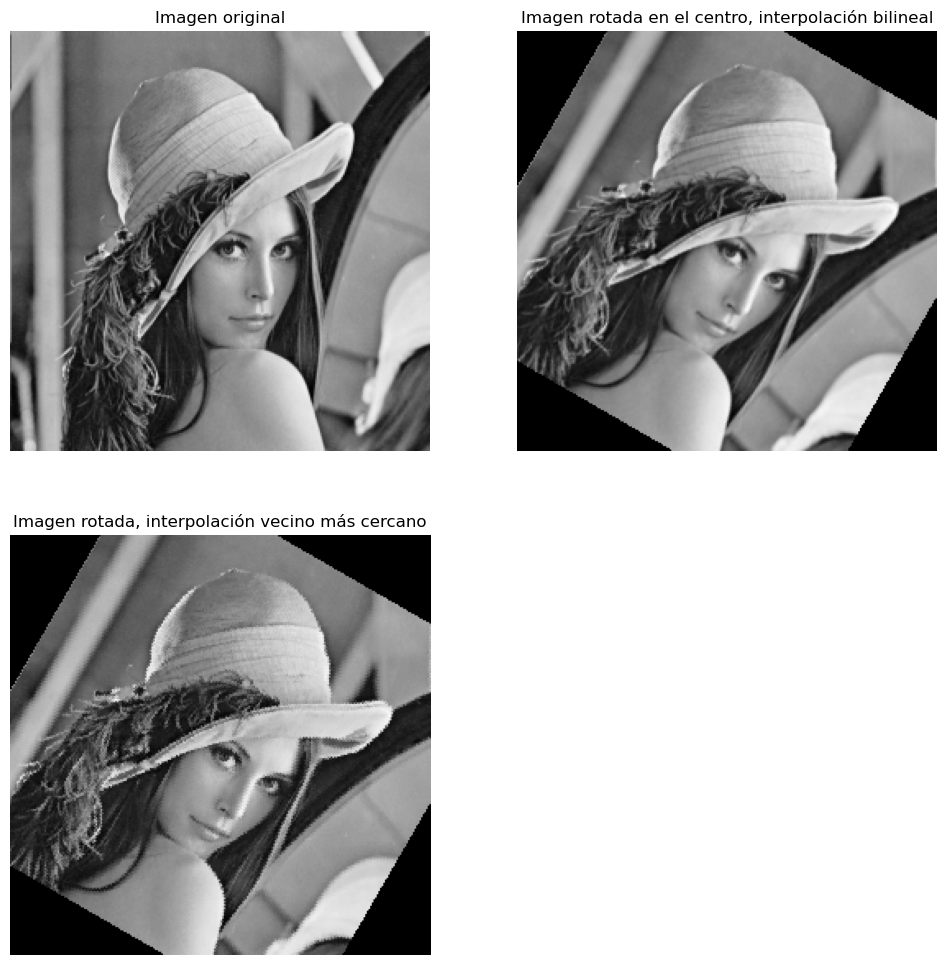

In [4]:
# Muestre las matrices correspondientes a las tres transformaciones 
def matriz_traslacion(tx, ty):
    return np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])

# Obtener las dimensiones de la imagen
alto, ancho = I.shape

# Calcular las matrices de transformación
T_traslacion_origen = matriz_traslacion(-ancho / 2, -alto / 2)
T_rotacion = matriz_rotacion(30)
T_traslacion_centro = matriz_traslacion(ancho / 2, alto / 2)

print("Matriz de traslación al origen:")
print(T_traslacion_origen)

print("Matriz de rotación:")
print(T_rotacion)

print("Matriz de traslación de vuelta al centro:")
print(T_traslacion_centro)

# Calcule la matriz de rotación en el centro como la composición de las tres transformaciones anteriores

T_rotacion_centro = np.dot(np.dot(T_traslacion_centro, T_rotacion), T_traslacion_origen)

print("Matriz de transformación compuesta:")
print(T_rotacion_centro)

# Aplique la transformación y muestre el resultado

imagen_rotada_centro_1 = transformar(I, T_rotacion_centro, 'bilineal')

imagen_rotada_centro_2 = transformar(I, T_rotacion_centro, 'vecino')

# Visualizar la imagen original y la imagen rotada en el centro
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(I, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(imagen_rotada_centro_1, cmap='gray')
plt.title('Imagen rotada en el centro, interpolación bilineal')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(imagen_rotada_centro_2, cmap='gray')
plt.title('Imagen rotada, interpolación vecino más cercano')
plt.axis('off')

#### Mostrar una transformación afin 

Matriz de transformación afín:
[[ 1.08374905e+00 -2.67269464e-03  1.00000000e+01]
 [ 5.91837454e-01  8.27504798e-01  2.00000000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


(-0.5, 255.5, 255.5, -0.5)

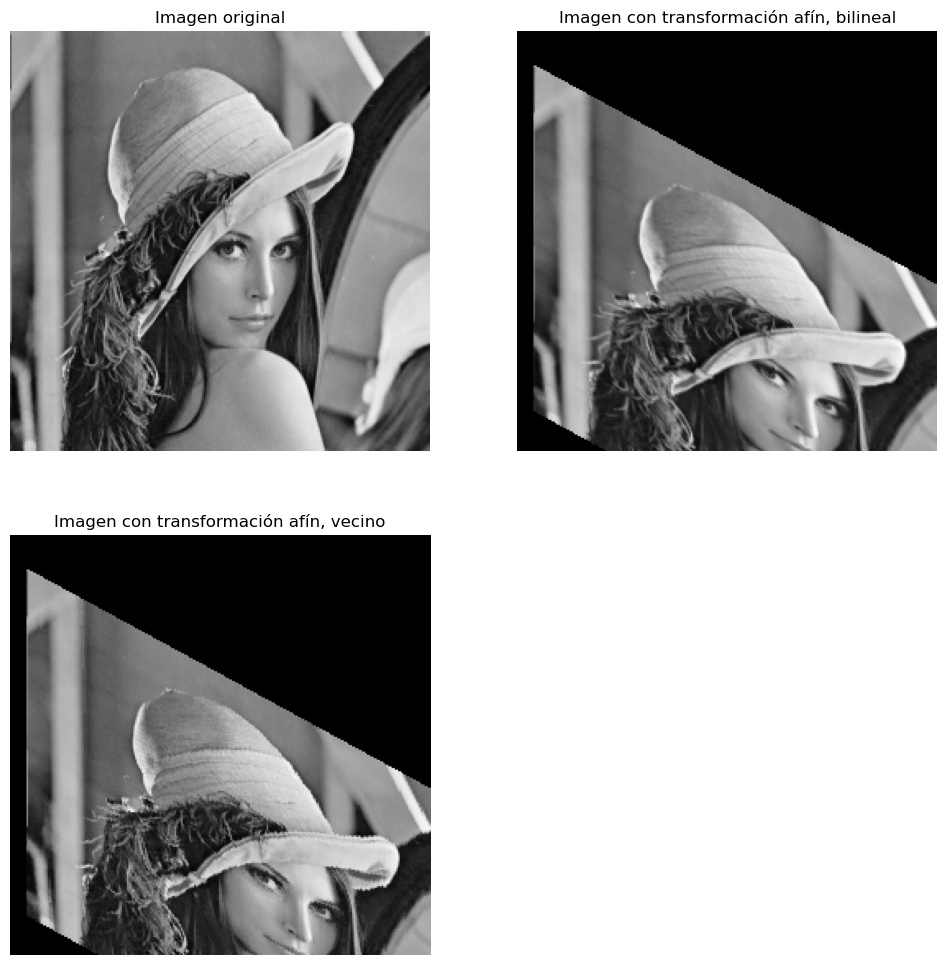

In [5]:
# Definir los parámetros de la transformación afín
tx, ty = 10, 20  # traslación en pixeles
rotacion_grados = 15  # rotación en grados
sx, sy = 1.2, 0.8  # escalado
shx, shy = 10, 20  # cizallamiento en grados

# Calcular las matrices de transformación
T_traslacion = matriz_traslacion(tx, ty)
T_rotacion = matriz_rotacion(rotacion_grados)
T_escalado = np.array([
    [sx, 0, 0],
    [0, sy, 0],
    [0, 0, 1]
])
T_cizallamiento = np.array([
    [1, np.tan(np.radians(shx)), 0],
    [np.tan(np.radians(shy)), 1, 0],
    [0, 0, 1]
])

# Calcular la matriz de transformación afín como la composición de las transformaciones
T_afin = np.dot(T_traslacion, np.dot(T_rotacion, np.dot(T_escalado, T_cizallamiento)))

print("Matriz de transformación afín:")
print(T_afin)

# Aplicar la transformación afín a la imagen
imagen_transformada_afin_1 = transformar(I, T_afin, 'bilineal')

imagen_transformada_afin_2 = transformar(I, T_afin, 'vecino')

# Visualizar la imagen original y la imagen transformada afín
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(I, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(imagen_transformada_afin_1, cmap='gray')
plt.title('Imagen con transformación afín, bilineal')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(imagen_transformada_afin_2, cmap='gray')
plt.title('Imagen con transformación afín, vecino')
plt.axis('off')

#### Mostrar una transformación proyectiva

Matriz de transformación proyectiva:
[[1.51816814e+00 1.35500072e-01 1.00000000e+01]
 [1.13453442e-01 1.52060692e+00 1.50000000e+01]
 [2.96951024e-03 3.06706170e-03 1.00000000e+00]]


(-0.5, 255.5, 255.5, -0.5)

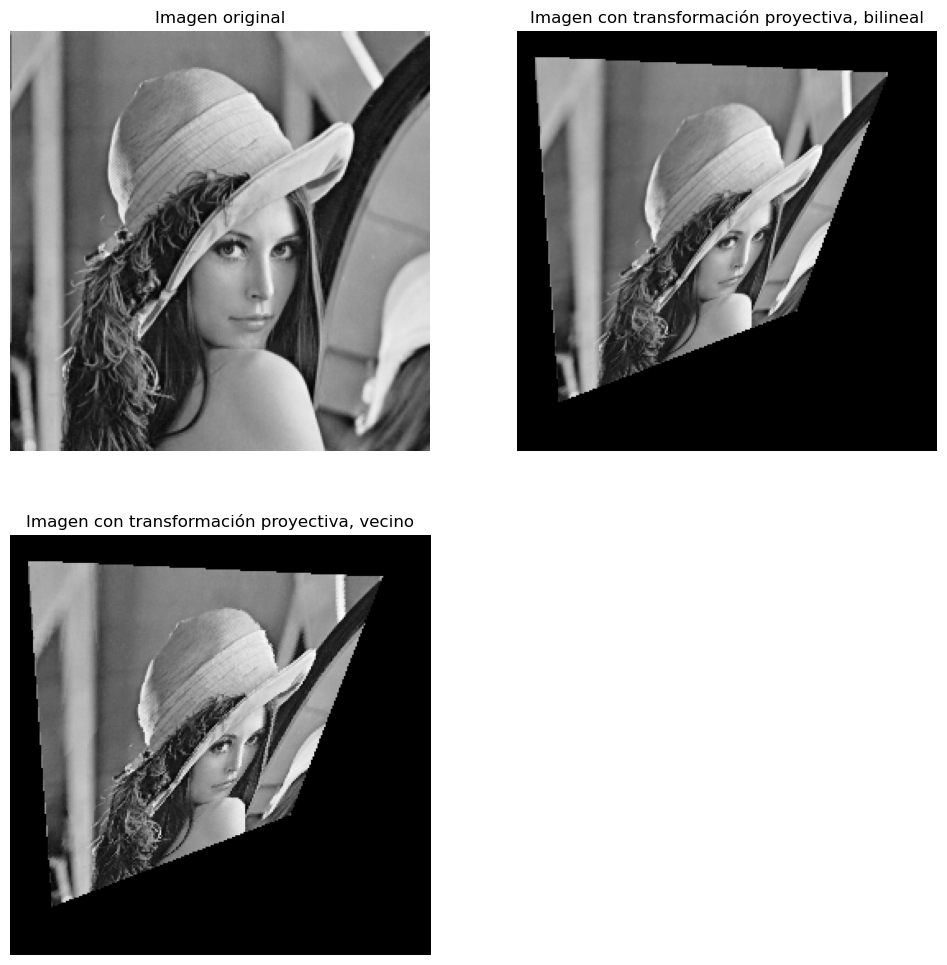

In [6]:
from cv2 import findHomography

# Puntos en la imagen original (esquinas)
src_points = np.array([[0, 0], [ancho-1, 0], [ancho-1, alto-1], [0, alto-1]], dtype=np.float32)

# Puntos en la imagen transformada
dst_points = np.array([[10, 15], [ancho-30, 25], [(2*ancho)//3, (2*alto)//3], [25, alto-30]], dtype=np.float32)

# Calcular la matriz de transformación proyectiva
#(Como la función para calcularla se implementa en el siguiente ejercicio, se usa la de OpenCV)
T_proyectiva, a = findHomography(src_points, dst_points)

print("Matriz de transformación proyectiva:")
print(T_proyectiva)

# Aplicar la transformación proyectiva a la imagen
imagen_transformada_proyectiva_1 = transformar(I, T_proyectiva, 'bilineal')
imagen_transformada_proyectiva_2 = transformar(I, T_proyectiva, 'vecino')

# Visualizar la imagen original y la imagen transformada proyectiva
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(I, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(imagen_transformada_proyectiva_1, cmap='gray')
plt.title('Imagen con transformación proyectiva, bilineal')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(imagen_transformada_proyectiva_2, cmap='gray')
plt.title('Imagen con transformación proyectiva, vecino')
plt.axis('off')

Se puede ver en todos los casos que la interpolación bilineal da un resultado de mejor calidad que la interpolación por vecino más cercano.

### 3. Implementar el cálculo de una matriz de transformación proyectiva a partir de un conjunto de  4 o más puntos correspondientes
Para chequear su implementación se puede comparar el resultado con cv2.findHomography por ejemplo


In [7]:
# Entradas:
#    puntosA   Nx2
#    puntosB   Nx2
#    con N>=4
# Salida
#    H         3x3    
def calcular_homografia(puntosA, puntosB):

    num_puntos = puntosA.shape[0]

    # Crear matrices M y b para resolver el sistema de ecuaciones Mh = b
    M = np.zeros((2 * num_puntos, 8))
    b = np.zeros(2 * num_puntos)

    for i in range(num_puntos):
        x, y = puntosA[i]
        x_p, y_p = puntosB[i]

        M[2*i] = [x, y, 1, 0, 0, 0, -x * x_p, -y * x_p]
        M[2*i + 1] = [0, 0, 0, x, y, 1, -x * y_p, -y * y_p]
        
        b[2*i] = x_p
        b[2*i + 1] = y_p
    
    if num_puntos==4:
        #Resolver el sistema de ecuaciones
        h = np.linalg.solve(M, b)
    else:
        # Resolver el sistema de ecuaciones usando mínimos cuadrados
        h, _, _, _ = np.linalg.lstsq(M, b, rcond=None)

    # Agregar el último elemento a h para construir la matriz H
    h = np.append(h, 1)

    # Cambiar la forma de h a una matriz 3x3
    H = h.reshape(3, 3)

    return H
    

Matriz de transformación proyectiva:
[[1.51816814e+00 1.35500072e-01 1.00000000e+01]
 [1.13453442e-01 1.52060692e+00 1.50000000e+01]
 [2.96951024e-03 3.06706170e-03 1.00000000e+00]]


(-0.5, 255.5, 255.5, -0.5)

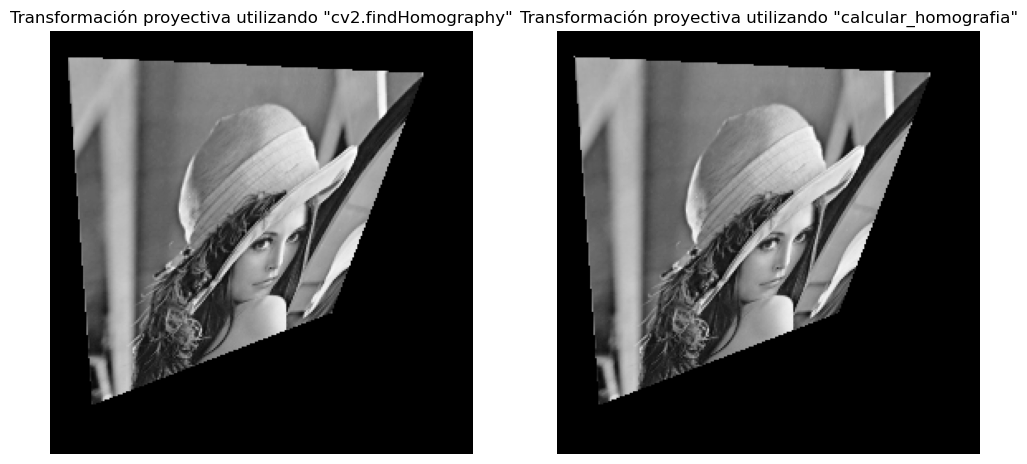

In [8]:
# Calcular la matriz de transformación proyectiva
T_proyectiva2 = calcular_homografia(src_points, dst_points)

print("Matriz de transformación proyectiva:")
print(T_proyectiva)

# Aplicar la transformación proyectiva a la imagen
imagen_transformada_proyectiva2 = transformar(I, T_proyectiva2, 'bilineal')

# Visualizar la imagen transformada calculando la homografía con las dos funciones
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imagen_transformada_proyectiva_1, cmap='gray')
plt.title('Transformación proyectiva utilizando "cv2.findHomography"')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagen_transformada_proyectiva2, cmap='gray')
plt.title('Transformación proyectiva utilizando "calcular_homografia"')
plt.axis('off')

Se verifica visualmente que el resultado de la función implementada sea el mismo que el de la función cv2.findHomography. El resultado parece ser el mismo.

#### Chequear la función implementada

In [9]:
# chequear la función calcularHomografía con un conjunto de puntos N=4
origen =  np.array([(0,0), (0,100), (100, 100), (100, 0)])
destino = np.array([(0,0), (0,100), (100, 50),  (100, 0)])
print(origen)
print(destino)

# calcular la homografía
H = calcular_homografia(origen, destino)

# aplicar a los puntos origen y verificar si el resultado son los puntos destino
puntos_origen_homogeneos = np.column_stack([origen, np.ones(origen.shape[0])])
puntos_transformados_homogeneos = np.dot(puntos_origen_homogeneos,np.transpose(H))

# Convertir las coordenadas homogéneas a coordenadas cartesianas
puntos_transformados = puntos_transformados_homogeneos[:, :2] / puntos_transformados_homogeneos[:, 2].reshape(-1, 1)
print(puntos_transformados)



[[  0   0]
 [  0 100]
 [100 100]
 [100   0]]
[[  0   0]
 [  0 100]
 [100  50]
 [100   0]]
[[  0.   0.]
 [  0. 100.]
 [100.  50.]
 [100.   0.]]


Al aplicar la función con un conjunto de 4 puntos, el resultado, como es de esperar, es exactamente los puntos de destino

In [10]:
# chequear la función calcularHomografía con un conjunto de puntos N>4
origen =  np.array([(0,0), (0,52), (0,100), (100, 100), (100, 0)])
destino = np.array([(0,0), (0,48), (0,100), (100, 50),  (100, 0)])
print(origen)
print(destino)


# calcular la homografía
H = calcular_homografia(origen, destino)

# aplicar a los puntos origen y verificar si el resultado es cercano a los puntos destino
puntos_origen_homogeneos = np.column_stack([origen, np.ones(origen.shape[0])])
puntos_transformados_homogeneos = np.dot(puntos_origen_homogeneos,np.transpose(H))

# Convertir las coordenadas homogéneas a coordenadas cartesianas
puntos_transformados = puntos_transformados_homogeneos[:, :2] / puntos_transformados_homogeneos[:, 2].reshape(-1, 1)
print(np.round(puntos_transformados))

[[  0   0]
 [  0  52]
 [  0 100]
 [100 100]
 [100   0]]
[[  0   0]
 [  0  48]
 [  0 100]
 [100  50]
 [100   0]]
[[  1.  -1.]
 [ -0.  50.]
 [ -1.  99.]
 [100.  50.]
 [100.   0.]]


Al aplicar la función a un conjunto de 5 puntos, el resultado, si bien no es exactamente el mismo ya que se hace una aproximación por mínimos cuadrados, es bastante cercano a los puntos de destino.

## Segmentación

### 4. Detección de líneas con la transformada de Hough

   
Se puede encontrar una buena explicación y pseudocódigo en los libros de [Burger & Burge](https://books.google.com.uy/books?id=YpzWCwAAQBAJ&printsec=frontcover#v=onepage&q&f=false).   
Se sugiere seguir dicho pseudocódigo para la implementación.

#### Dibujo de líneas

In [11]:
def plot_lineas_hough(fig, I, L):
    '''
    Grafica sobre la figura especificada las líneas definidas en L

    Args
    ----
    fig : Numero de la figura de matplotlib donde se plotean las líneas
    L :   [[theta, rho, votos], [theta, rho, votos], .....]
          Lista de rectas detectadas con la función lineas_hough 

    Returns
    -------
    Nothing

    '''
    
    # Implementar
    x_centro=I.shape[1]/2
    y_centro=I.shape[0]/2

    for line in L:
        theta = line[0]
        rho = line[1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = x_centro + b * rho
        y0 = y_centro + a * rho

        x1 = x0 - 1000 * (a)
        y1 = y0 + 1000 * (b)
        x2 = x0 + 1000 * (a)
        y2 = y0 - 1000 * (b)
        fig.plot([x1, x2], [y1, y2])

    fig.set_xlim(0, I.shape[1])
    fig.set_ylim(I.shape[0], 0)

#### Mostrar el funcionamiento de plot_lineas_hough para distintos valores theta-rho
Notar que se puede implementar y probar **plot_lineas_hough** antes de implementar **lineas_hough**.  
Se sugiere dejar andando correctamente **plot_lineas_hough** primero. Esto permitirá luego probar rápidamente los resultados de **lineas_hough**.
  

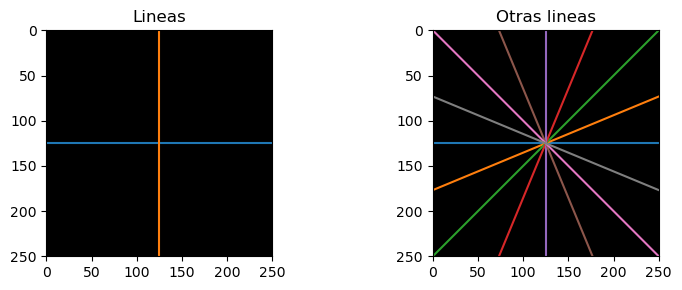

In [12]:
# Imagen vacía a plottear
zeros = np.zeros((250,250))

# líneas horizontal y vertical que pasan por la mitad de la imagen
lineas = [[0,0],[np.pi/2,0]]    
# lineas separadas por un ángulo de pi/8 radianes
lineas2 = [[0,0],[np.pi/8,0],[np.pi/4,0],[3*np.pi/8,0],[np.pi/2,0],[5*np.pi/8,0],[3*np.pi/4,0],[7*np.pi/8,0]] 

# Inicializar figura
fig, ax = plt.subplots(1,2,figsize=(8,3))

ax[0].imshow(zeros, cmap='gray')
# Plot lineas
plot_lineas_hough(ax[0], zeros, lineas)
ax[0].set_title("Lineas")
ax[1].imshow(zeros, cmap='gray')
# Plot lineas2
plot_lineas_hough(ax[1], zeros, lineas2)
ax[1].set_title("Otras lineas")
fig.tight_layout()

Las imágenes de salida deberían ser del estilo:


![Alt text](imagenes/output_plot_hough.png)

Al implementar la función se obtiene exactamente el resultado esperado

#### Detección de líneas

In [13]:

    

def lineas_hough(I, m, n, minimo_votos, debug=False):
    '''
    Detección de líneas mediante la Transformada de Hough
    
    Args
    ----
    I : imagen binaria (resultado de un detector de bordes por ejemplo)
    m, n : Enteros que determinan las dimensiones del acumulador
           m: cantidad de pasos en Theta
           n: cantidad de pasos en Rho
    minimo_votos : Cantidad mínima de votos que debe tener una recta 
    debug : Booleano opcional. En caso de ser verdadero, se muestra la imagen del acumulador
    
    Returns
    -------
    L : [[theta, rho, votos], [theta, rho, votos], .....]
        Lista con las rectas detectadas donde cada elemento de la lista es una terna [theta, rho, votos]
        La lista está ordenada en forma decreciente en la cantidad de votos 

    '''
    
    # Implementar
    # Calcular espacio de parámetros
    M, N = I.shape
    x_r, y_r = M/2, N/2
    d_theta = np.pi/m
    d_r = np.sqrt(M**2+N**2)/n
    j0 = n/2

    # Inicializar acumulador
    A = np.zeros((m, n), dtype=int)

    for u in range(M):
        for v in range(N):
            if I[u,v]>0:
                (x,y)=(u-x_r,v-y_r)
                for i in range(m):
                    theta = d_theta * i
                    r = x*np.cos(theta) + y*np.sin(theta)
                    j = int(j0 + r/d_r)
                    A[i,j] = A[i,j] + 1

    # Extraer líneas con votos mayores al mínimo
    L=[]
    for i in range(m):
        for j in range(n):
            if A[i,j]>=minimo_votos:
                theta = i * d_theta
                r = (j-j0) * d_r
                a = A[i,j]
                l=[theta, r, a]
                L.append(l)
    L.sort(key=lambda x: x[2], reverse=True)

    # Mostrar imagen del acumulador si debug es True
    if debug:
        # Calcular la relación de aspecto
        rango_rho = n*d_r
        rango_theta = m*d_theta
        relacion_aspecto = rango_rho / rango_theta
        
        plt.figure()
        plt.imshow(np.flip(A, axis=0), cmap='hot', extent=[-d_r*n/2, d_r*n/2, 0, m*d_theta], aspect=relacion_aspecto)
        plt.xlabel('Rho')
        plt.ylabel('Theta')
        plt.colorbar()

    return L



La implementación se basa en el seudocódigo mostrado en el libro de Burger & Burge

#### Mostrar el funcionamiento de lineas_hough sobre imágenes artificiales 
Para cada imagen artificial:   
a) detectar líneas  
b) mostrar el acumulador y plotear las rectas    
c) relacionar el contenido del acumulador con las rectas correspondientes    

[[0.0, -50.47771785649585, 2]]


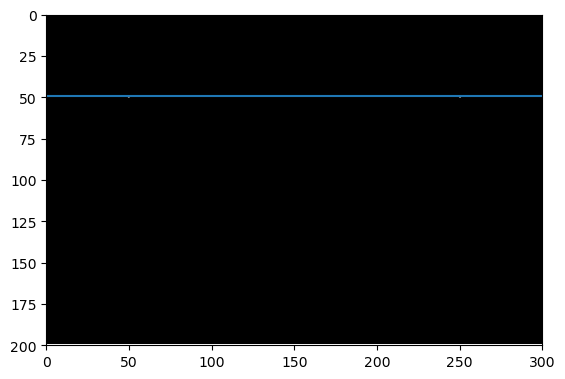

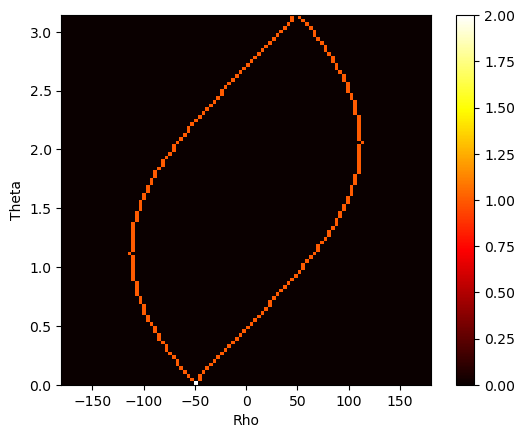

In [14]:
#Ejemplo 1 
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[50,250]=255


fig, ax= plt.subplots()
ax.imshow(I, cmap='gray')

L = lineas_hough(I, 100, 100, 2, debug=True)
plot_lineas_hough(ax, I, L)
print(L)


Se puede ver que el único punto blanco del acumulador (el blanco corresponde a rectas con 2 votos) corresponde a rho=-50 y theta=0, esto coincide con la recta ploteada en la imagen, la cual es horizontal y esta 50 pixeles arriba del centro de la imagen.

[[1.5707963267948968, -100.9554357129917, 2]]


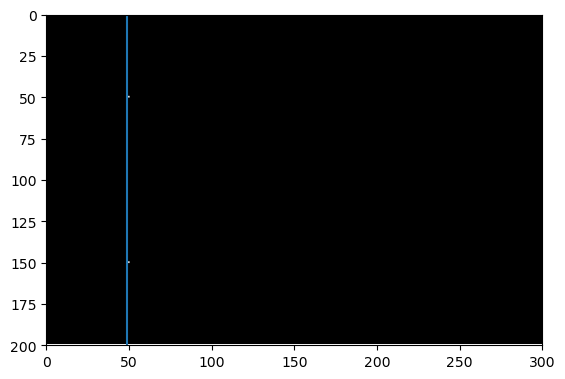

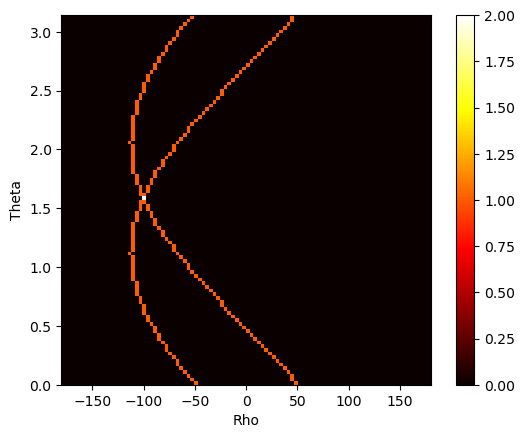

In [15]:
#Ejemplo 2
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[150,50]=255

fig, ax= plt.subplots()
ax.imshow(I, cmap='gray')

L = lineas_hough(I, 100, 100, 2, debug=True)
plot_lineas_hough(ax, I, L)
print(L)

Se aprecia que el único punto blanco del acumulador corresponde a rho=-100 y theta=pi/2, esto coincide con la recta ploteada en la imagen, la cual es vertical y está 100 pixeles a la izquierda del centro de la imagen.

[[2.356194490192345, -36.05551275463989, 2]]


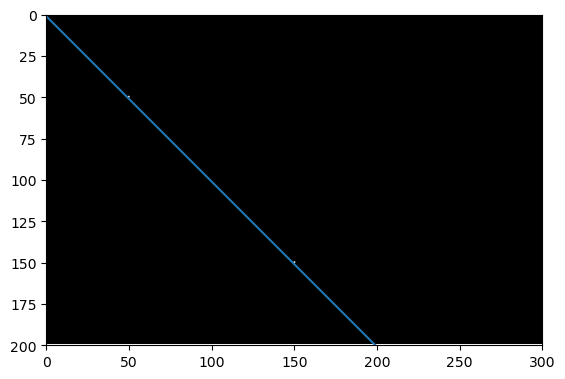

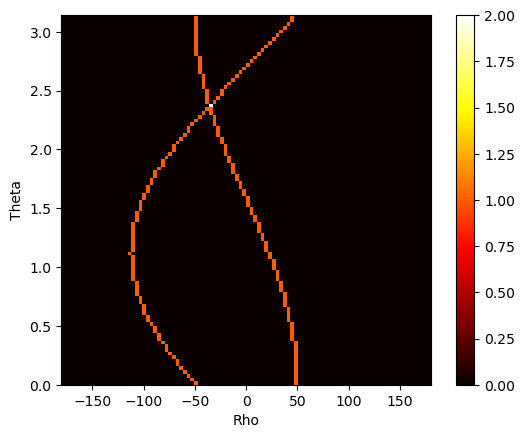

In [16]:
#Ejemplo 3
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[150,150]=255

fig, ax= plt.subplots()
ax.imshow(I, cmap='gray')

L = lineas_hough(I, 100, 100, 2, debug=True)
plot_lineas_hough(ax, I, L)
print(L)

El único punto blanco del acumulador corresponde a rho=-36 y theta=3pi/4, esto coincide con la recta ploteada en la imagen, la cual está girada 135° en sentido antihorario con respecto a la horizontal y está a una distancia de aproximadamente 36 pixeles del centro de la imagen.

[[0.0, -50.47771785649585, 2], [0.7853981633974484, 32.449961479175904, 2], [2.356194490192345, -36.05551275463989, 2]]


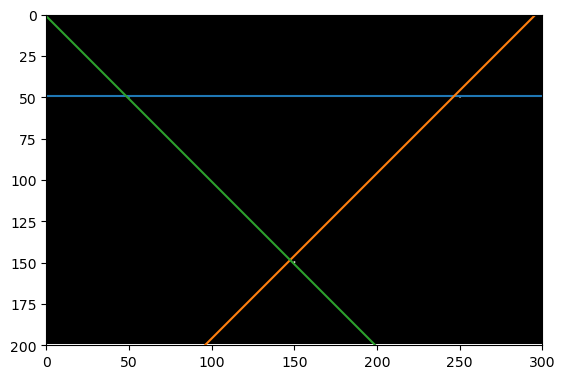

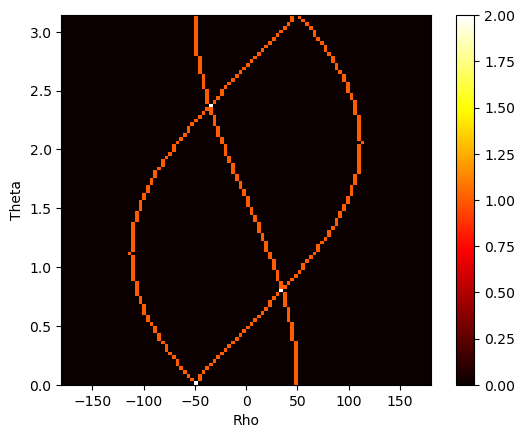

In [17]:
# Ejemplo 4
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[50,250]=255
I[150,150]=255

fig, ax= plt.subplots()
ax.imshow(I, cmap='gray')

L = lineas_hough(I, 100, 100, 2, debug=True)
plot_lineas_hough(ax, I, L)
print(L)


Se distinguen 3 puntos blancos en el acumulador (3 rectas con 2 votos) corresponden a los puntos (rho,theta)=(-50,0),(32,pi/4),(-36,3pi/4), esto coincide con las recta ploteadas en la imagen, de las cuales 2 ya se habían ploteado en imágenes anteriores y la restante, se puede ver que está girada 45° en sentido antihorario con respecto a la horizontal y está a una distancia de aproximadamente 32 pixeles del centro de la imagen.

#### Mostrar el funcionamiento de lineas_hough sobre la imagen trapecio.png
Comentar resultados al variar la resolución en el espacio de parámetros (m y n en la función lineas_hough)

(0.0, 434.0, 264.0, 0.0)

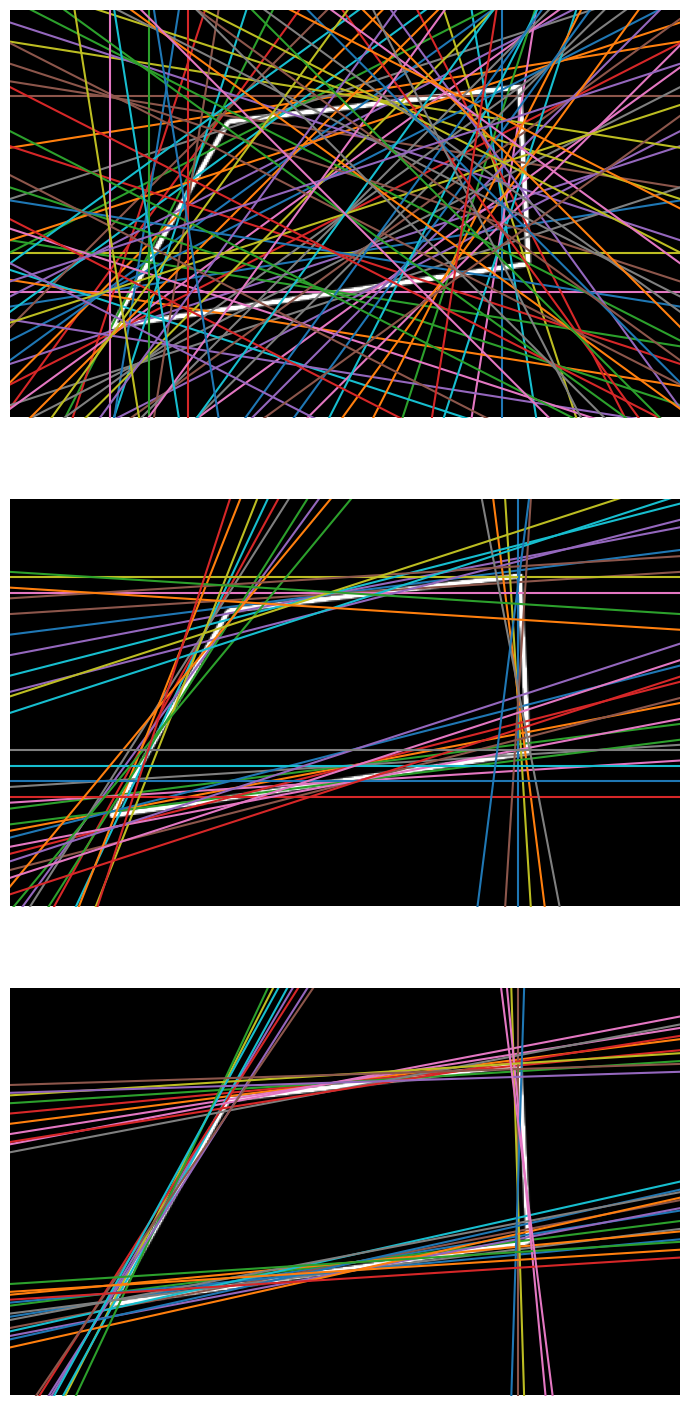

In [18]:
"""Se pasa la imagen a niveles de gris tomando el promedio de los 3 colores
y se invierte para que las linas sean blancas"""
I= 255 - np.mean(imread('imagenes/trapecio.png'), axis=2)

L_1 = lineas_hough(I, 20, 20, 300)
L_2 = lineas_hough(I, 50, 50, 300)
L_3 = lineas_hough(I, 100, 100, 300)

fig, ax= plt.subplots(3,1, figsize=(12,18))
ax[0].imshow(I, cmap='gray')
plot_lineas_hough(ax[0], I, L_1)
ax[0].axis('Off')

ax[1].imshow(I, cmap='gray')
plot_lineas_hough(ax[1], I, L_2)
ax[1].axis('Off')

ax[2].imshow(I, cmap='gray')
plot_lineas_hough(ax[2], I, L_3)
ax[2].axis('Off')

La función detecta más líneas de las que existen, esto se debe a que las líneas no tienen un pixel de grosor, si no que tienen grosor de varios píxeles. Al aumentar la resolución del espacio de parámetros, se obtienen menos rectas si se usa el mismo mínimo de votos, y las rectas que se obtienen son más coherentes con lo que se ve en la imágen en cuanto a posición y ángulo. Esto tiene sentido ya que si el valor exacto de rho y theta no está en el espacio de parámetros, la recta hallada será la más cercana, por lo que al aumentar la resolución, esta recta será mas parecida a la recta real.

### 5. Aplicación: Segmentación de imágenes de documentos

En esta parte se usará un subset de la base RVL-CDIP que contiene imágenes de documentos escaneados.
https://adamharley.com/rvl-cdip/  


Utilizando herramientas vistas en el curso (ej. análisis en frecuencia, transformaciones geométricas, segmentación por umbral, detección de bordes, lineas y regiones, morfología, etiquetado de regiones, entre otros) se buscará identificar en cada imagen:  

**Tareas**

1. Orientación general del documento en la imagen.  ¿El documento está en formato vertical o está apaisado? 
2. Ángulo de giro. Ángulo a girar el documento en sentido horario para que las líneas y/o texto queden horizontales.  
3. ¿El documento es un formulario o tabla? Se entenderá por formulario o tabla un documento que cuente con algunas líneas verticales y horizontales. 
4. ¿El documento tiene columnas de texto? El documento tiene agrupaciones de texto en columnas por varias filas.  
5. Límites horizontales del documento. Indicar la columna de inicio y fin del núcleo principal del documento. En caso que (4) sea afirmativo, indicar también las posiciones horizontales que separan las columnas de texto.    
6. Alto de líneas. Distancia vertical en píxeles entre la línea de base de una fila y la de la siguiente.  
7. Ancho de letra. En los casos que el documento tenga un tipo de letra "monospaced" (https://en.wikipedia.org/wiki/Monospaced_font) se podrá determinar el ancho de letra como la distancia horizontal en píxeles entre el comienzo de una letra y de la siguiente. 
8. ¿El documento es sólo texto y/o líneas o contiene alguna figura? Se entenderá por figura un conjunto conexo de píxeles mayor al 1% del área de la imagen y que no está compuesto por texto/líneas y que tampoco es una región quasi-uniforme (ej. un rectángulo quasi-uniforme no se considera una figura)

En el pdf adjunto a este notebook hay ejemplos de las imágenes de documentos y de los resultados esperados para cada una de las tareas. 


**Herramientas**  
Para la resolución de esta parte se podrá usar funciones de numpy, scipy, scikit-image, de OpenCV y herramientas de Fiji. 

**Resultados esperados**
* El problema se plantea en forma abierta y por lo tanto no hay una forma única de resolver cada tarea. La idea es que exploren las distintas técnicas y algoritmos vistos a lo largo del curso sobre un problema concreto
* El conjunto de imágenes que les dejamos disponibles tiene cierta variabilidad por lo que, para las distintas tareas, habrá algunas imágenes más complicadas que otras. No esperen un funcionamiento perfecto de sus soluciones. 
* Para cada tarea implementada, 
  * se valorará que comenten él o los posibles métodos que la podrían resolver, antes de realizar una implementación concreta
  * implementen alguno de esos métodos en la función cuyo esqueleto le pasamos. Pueden hacer funciones auxiliares si lo necesitan. Alternativamente pueden hacer un procedimiento o una macro si usan Fiji.
  * muestren tests de su método sobre algunas imágenes
  * opcionalmente pueden mostrar, si la tarea lo permite, resultados cuantitativos sobre el conjunto de imágenes (por ejemplo el porcentaje de acierto)
  * comenten en qué casos funciona y qué casos son difíciles para el método (no es necesario un listado exhaustivo)  
* Implementaciones  
  * No se espera que un método implementado para una tarea funcione para todas o casi todas las imágenes. 
  * Las tareas tienen diferente dificultad. Para algunas será más sencillo hacer un método general y para otras se podrá hacer algo que funcione para un conjunto más restringido de imágenes. Hagan métodos no muy extensos, los testean y discuten resultados.
  * Realizar al menos 5 de las 8 tareas
   
  



##### 5.1 Orientación general

Discusión de métodos, pruebas

[[[  0 919 714 919]]

 [[712 854 712 173]]

 [[714 856 714   0]]

 [[267 915 683 915]]]


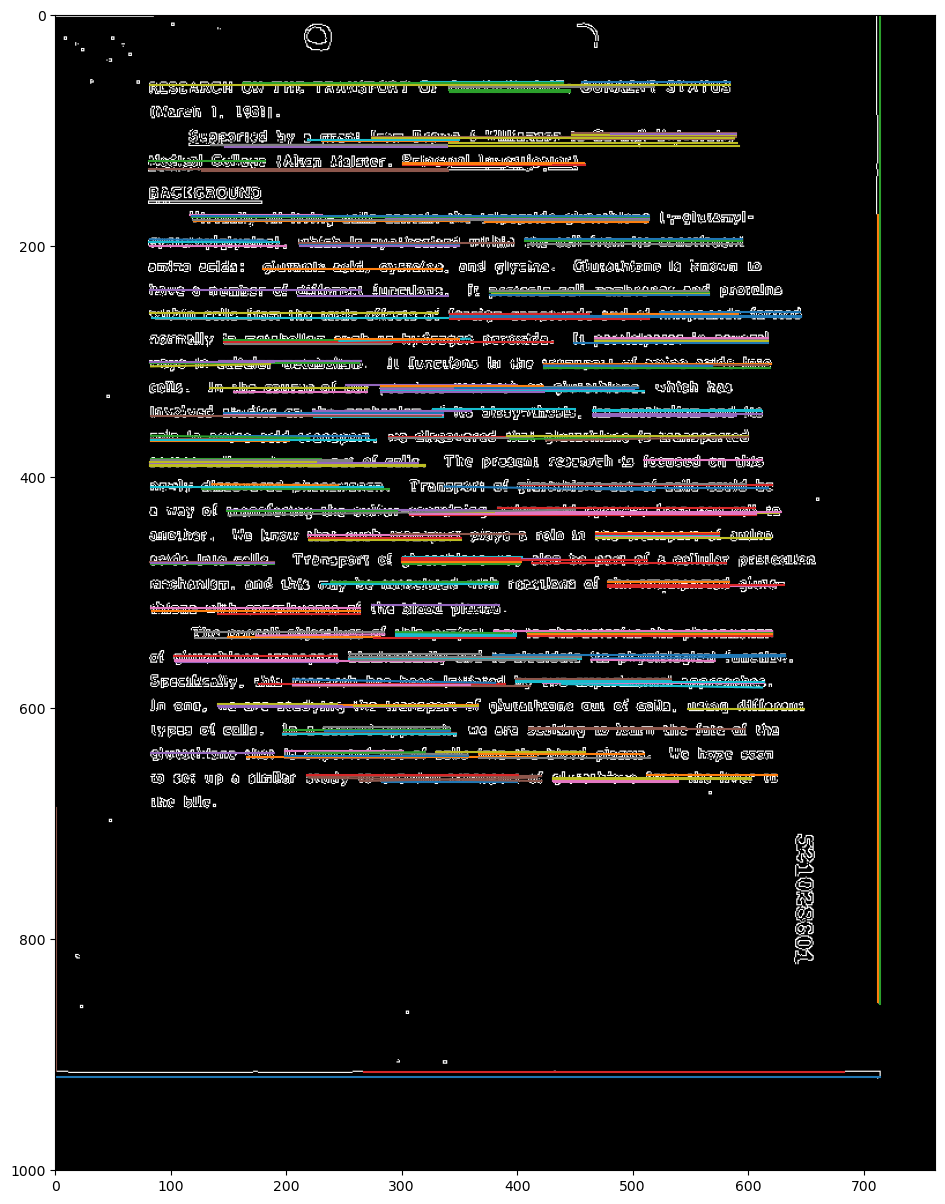

In [19]:
I=imread(dir_base_documentos+'/0000152641.tif')

fig, ax= plt.subplots(figsize=(15,15))

edges = cv2.Canny(I, 50, 150)

ax.imshow(edges, cmap='gray')
ax.set_xlim(0, I.shape[1])
ax.set_ylim(I.shape[0], 0)


L = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=8)

# Draw the lines
if L is not None:
    for i in range(0, len(L)):
        l = L[i][0]
        ax.plot((l[0], l[2]), (l[1], l[3]))
        
print(L[0:4])

El método se basa en encontrar los segmentos de recta correspondientes a los renglones (que son la mayoría) y detectar si estos están horizontales o verticales. En caso de que estén horizontales la orientación del documento es vertical y viceversa.

Implementación

In [20]:
def tiene_orientacion_vertical(I_doc):
    """
    Determina la orientación del documento en la imagen.

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    orientacion_vertical (bool): Orientación del documento, puede ser 'vertical' (True) o 'apaisado' (False)
    """
    
    #IMPLEMENTAR
    
    # Detectar bordes usando el algoritmo de Canny
    edges = cv2.Canny(I_doc, 50, 150)
    
    # Aplicar la transformada de Hough para encontrar líneas en la imagen usando cv2.HoughLinesP
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=8)

    # Contar la cantidad de líneas verticales y horizontales
    vertical_lines = 0
    horizontal_lines = 0

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]

            # Calcular la inclinación de la línea
            slope = (y2 - y1) / (x2 - x1 + 1e-8)

            if abs(slope) < 0.5:  # Línea horizontal
                horizontal_lines += 1
            elif abs(slope) > 2:  # Línea vertical
                vertical_lines += 1

    # Determinar la orientación del documento
    orientacion_vertical = horizontal_lines > vertical_lines

    return orientacion_vertical

Tests sobre imágenes

In [21]:
gt=pd.read_csv('E2_ej5_datos_ground_truth.csv')
filenames=os.listdir(dir_base_documentos)
filenames.sort()

resultado=[]
for filename in filenames:
    image_directory=os.path.join(dir_base_documentos, filename)
    I=imread(image_directory)
    resultado.append(tiene_orientacion_vertical(I))  

print('Porcentaje de acierto: ' + str(sum(gt['orientacion_vertical']==resultado)/len(resultado)))

Porcentaje de acierto: 0.9078014184397163


F1 score: 0.9442060085836909


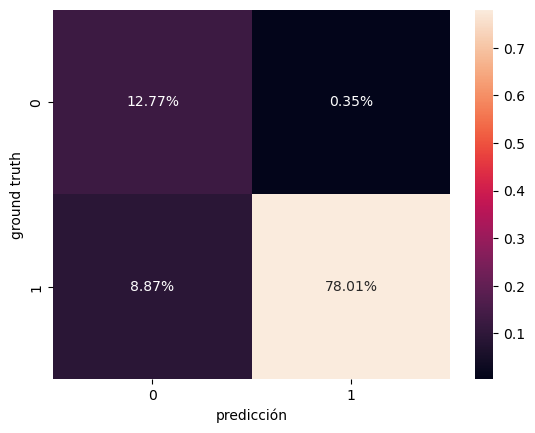

In [22]:
cf_matrix = confusion_matrix(gt['orientacion_vertical'], resultado)
ax= sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')
ax.set_xlabel('predicción')
ax.set_ylabel('ground truth')

f1= f1_score(gt['orientacion_vertical'], resultado)

print('F1 score: '+str(f1))

Se obtuvo un buen resultado en la implementación de esta función, lo cual se ve reflejado en el alto porcentaje de acierto y F1 score cercano a 1.

##### 5.2 Ángulo de giro

Discusión de métodos, pruebas

396 381
500 381
0.0


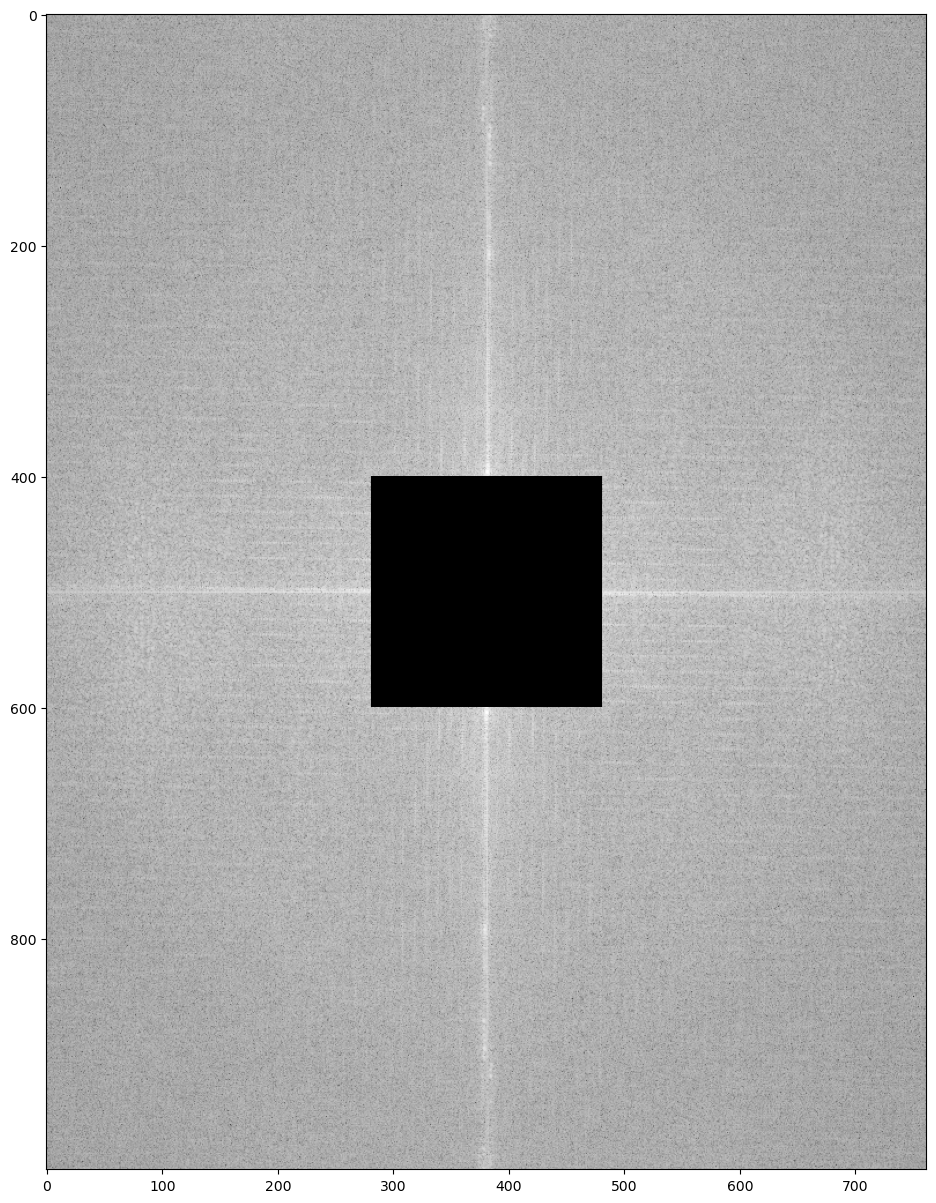

In [23]:
I=imread(dir_base_documentos+'/0000332006.tif')

fig, ax= plt.subplots(figsize=(15,15))

h,w= I.shape

f = np.fft.fft2(I)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

magnitude_spectrum[h//2-100:h//2+100,w//2-100:w//2+100]=0

peak_y, peak_x = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)

print(peak_y, peak_x)

center_y, center_x = np.array(magnitude_spectrum.shape) // 2

print(center_y, center_x)

delta_y = center_y - peak_y
delta_x = peak_x - center_x

# Calcula el ángulo en grados
angulo = np.degrees(np.arctan2(delta_y, delta_x))

if angulo > 45:  # Línea vertical
    angulo=angulo-90
elif angulo < -45: # Línea vertical
    angulo=angulo+90

print(angulo)

ax.imshow(magnitude_spectrum, cmap='gray')



La implementación se basa en la idea de que los renglones generan componentes de alta frecuencia en la transformada de fourier. Por lo tanto si se hace la transformada, se eliminan los componentes de baja frecuencia y se halla el ángulo en el que se encuentra el máximo valor, este debería ser el ángulo de los renglones, que se corresponde con el ángulo de giro del documento.

Implementación

In [24]:
def angulo_de_giro(I_doc):
    """
    Determina el ángulo (en grados) a girar la imagen en sentido horario 
    para que las líneas y/o texto del documento queden horizontales.

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    angulo (double): ángulo en grados
    """

    h,w= I_doc.shape
    
    # Calcula la Transformada de Fourier 2D y aplica un desplazamiento para centrarla
    f = np.fft.fft2(I_doc)
    fshift = np.fft.fftshift(f)

    # Calcula la magnitud de la transformada de Fourier 2D y la escala logarítmica
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    
    # Se eliminan los picos correspondientes a bajas frecuencias, ya que los renglones tienen alta frecuencia
    magnitude_spectrum[h//2-20:h//2+20,w//2-20:w//2+20]=0

    # Encuentra las coordenadas del pico máximo en el espectro de magnitud
    peak_y, peak_x = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)

    # Calcula el ángulo con respecto al centro de la imagen
    center_y, center_x = np.array(magnitude_spectrum.shape) // 2
    delta_y = center_y - peak_y
    delta_x = peak_x - center_x

    # Calcula el ángulo en grados
    angulo = np.degrees(np.arctan(delta_y / (delta_x+1e-8)))
    
    if angulo > 45:  # Línea vertical
        angulo=angulo-90
    elif angulo < -45: # Línea vertical
        angulo=angulo+90

    angulo=round(angulo,1)
    return angulo

Tests sobre imágenes

In [25]:
resultado=[]
for filename in filenames:
    image_directory=os.path.join(dir_base_documentos, filename)
    I=imread(image_directory)
    resultado.append(angulo_de_giro(I))
    
print('MSE en todo el conjunto de imágenes: '+str(np.mean((gt['angulo']-np.array(resultado))**2)))
print('MSE en imágenes con orientación vertical: '+str(np.mean(((gt['angulo']-np.array(resultado))**2)[gt['orientacion_vertical']==1])))

MSE en todo el conjunto de imágenes: 1064.5658865248236
MSE en imágenes con orientación vertical: 0.12628571428571428


La funcion supone que la imágen tiene orientación vertical, por lo que intenta hallar águlos entre -45 y 45 grados. Es por esto que al aplicarla a todos los documentos por igual se obtiene un MSE alto, pero al aplicarla únicamente a los documentos con orientación vertical, el MSE baja a un valor razonable.

In [26]:
comp=pd.DataFrame()
comp['angulo_real']=gt['angulo']
comp['angulo detectado']=resultado
print(comp.head(10))

   angulo_real  angulo detectado
0          0.0              -0.0
1          0.0              -0.0
2         -0.9              -0.6
3         -0.3              -0.0
4          0.0              -0.0
5          0.0              -0.0
6          0.0              -0.0
7          0.2               0.4
8          0.7              -0.0
9         -0.3              -0.8


Comparando los resultados obtenidos para las primeras 10 imágenes se puede ver que si bien en muchos casos el ángulo obtenido no es exactamente el real, los valores se mantienen en el orden y en general tienen el signo adecuado.

Text(0, 0.5, 'Ángulo')

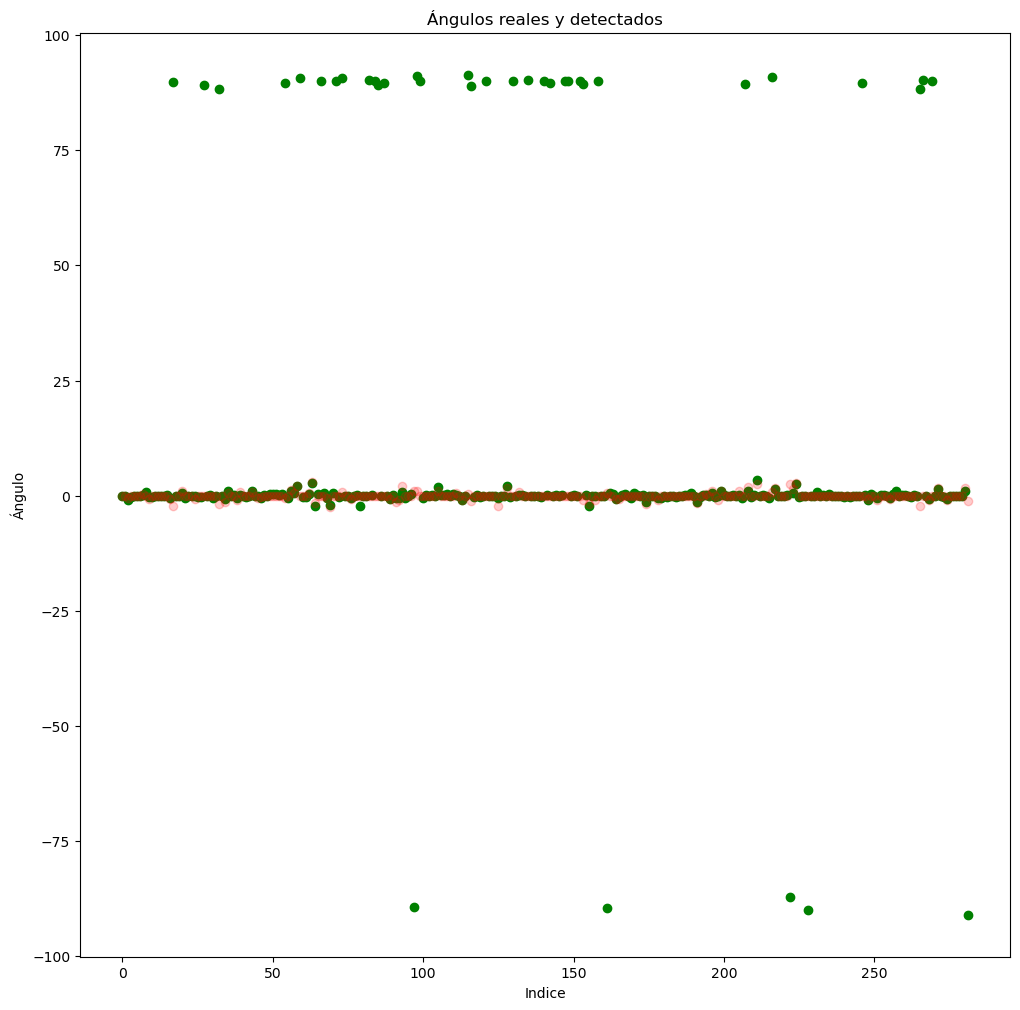

In [27]:
fig, ax= plt.subplots(figsize=(12,12))

ax.scatter(comp.index, comp['angulo_real'], color='g')
ax.scatter(comp.index, comp['angulo detectado'], color='r', alpha=0.2)
ax.set_title('Ángulos reales y detectados')
ax.set_xlabel('Indice')
ax.set_ylabel('Ángulo')

Los ángulos reales se muestran en verde, mientras que los detectados se muestran en rojo. Se puede ver que debido a la forma en que está definida la función, nunca se detectan los ángulos de las imágenes con orientación horizontal.

##### 5.3 Es un formulario o tabla ?

Discusión de métodos, pruebas

51


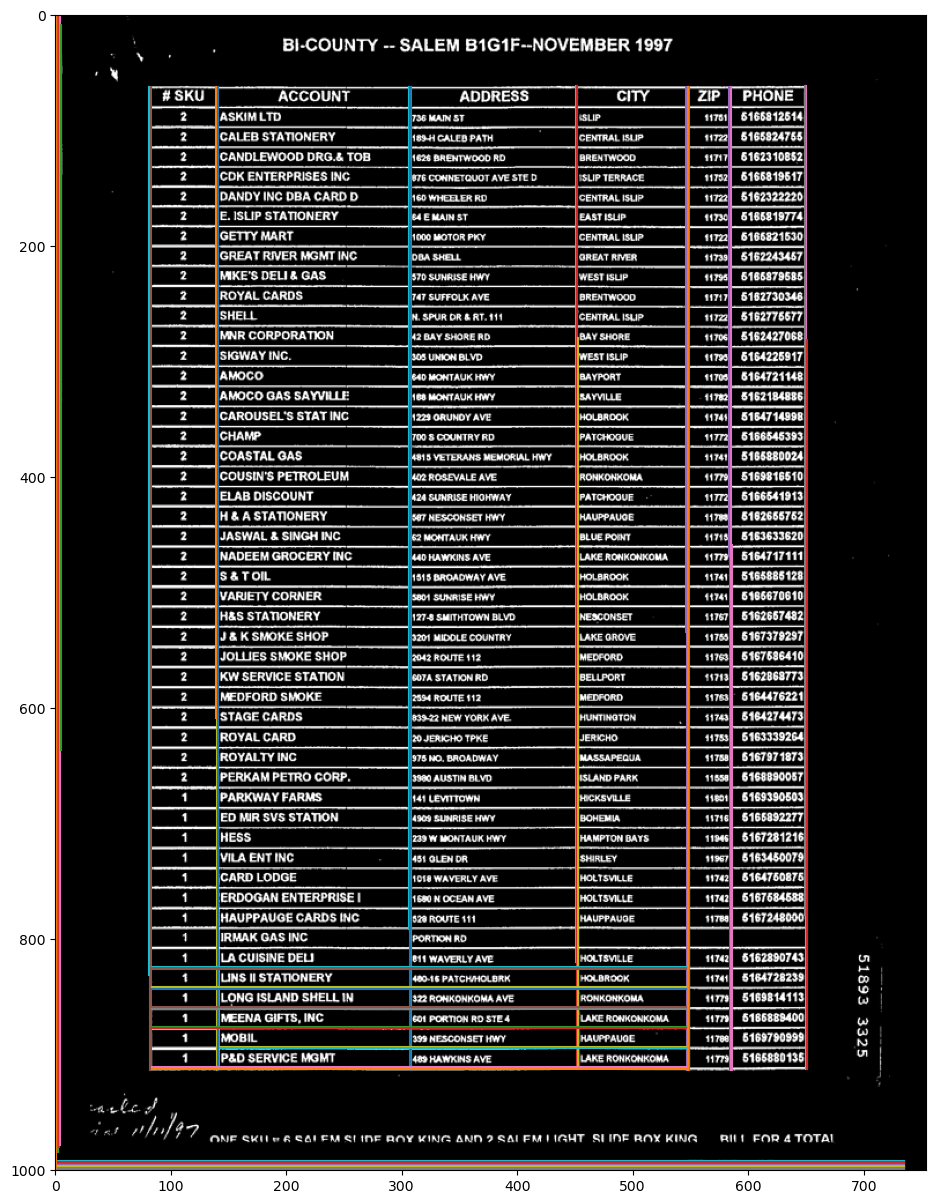

In [28]:
I=imread(dir_base_documentos+'/518933325+-3327.tif')

fig, ax= plt.subplots(figsize=(15,15))

inverse= 255-I

ax.imshow(inverse, cmap='gray')
ax.set_xlim(0, I.shape[1])
ax.set_ylim(I.shape[0], 0)


L = cv2.HoughLinesP(inverse, 1, np.pi / 180, 100, minLineLength=400, maxLineGap=2)

# Draw the lines
if L is not None:
    for i in range(len(L)):
        l = L[i][0]
        ax.plot((l[0], l[2]), (l[1], l[3]))

print(len(L))

Una tabla se caracteriza por tener líneas continuas y largas, por lo tanto en este método se busca encontrar este tipo de lineas utilizando la transformada de hough y aplicar un umbral para el cual si se detectan más de esa cantidad de líneas la imagen es clasificada como tabla.

Implementación

In [29]:
def es_tipo_tabla(I_doc):
    """
    Determina si el documento en la imagen es tipo formulario/tabla

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    es_tabla (bool): Verdadero si el documento en la imagen es tipo formulario/tabla
    """

    # IMPLEMENTAR #
    
    inverse= 255-I_doc
    
    lines = cv2.HoughLinesP(inverse, 1, np.pi / 180, 100, minLineLength=400, maxLineGap=2)
    
    threshold=30
    
    es_tabla=False
    if lines is not None:
        if len(lines) > 30:
            es_tabla=True

    return es_tabla

Tests sobre imágenes

In [30]:
resultado=[]
for filename in filenames:
    image_directory=os.path.join(dir_base_documentos, filename)
    I=imread(image_directory)
    resultado.append(es_tipo_tabla(I))
    
print('Porcentaje de acierto: ' + str(sum(gt['es_tabla']==resultado)/len(resultado)))

Porcentaje de acierto: 0.7836879432624113


F1 score: 0.46956521739130436


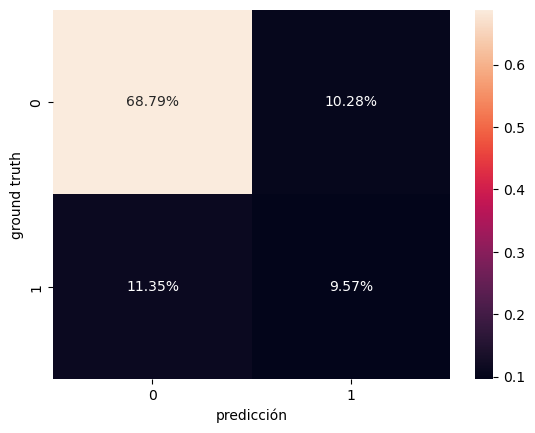

In [31]:
cf_matrix = confusion_matrix(gt['es_tabla'], resultado)
ax= sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')
ax.set_xlabel('predicción')
ax.set_ylabel('ground truth')

f1= f1_score(gt['es_tabla'], resultado)

print('F1 score: '+str(f1))

La función parece tener un buen desempeño si se juzga por el porcentaje de acierto, pero al ver el F1 score es bajo, y esto se debe a que clasificó incorrectamente más de la mitad de los documentos que eran una tabla.

##### 5.4 ¿El documento tiene texto en columnas?

Discusión de métodos, pruebas

4


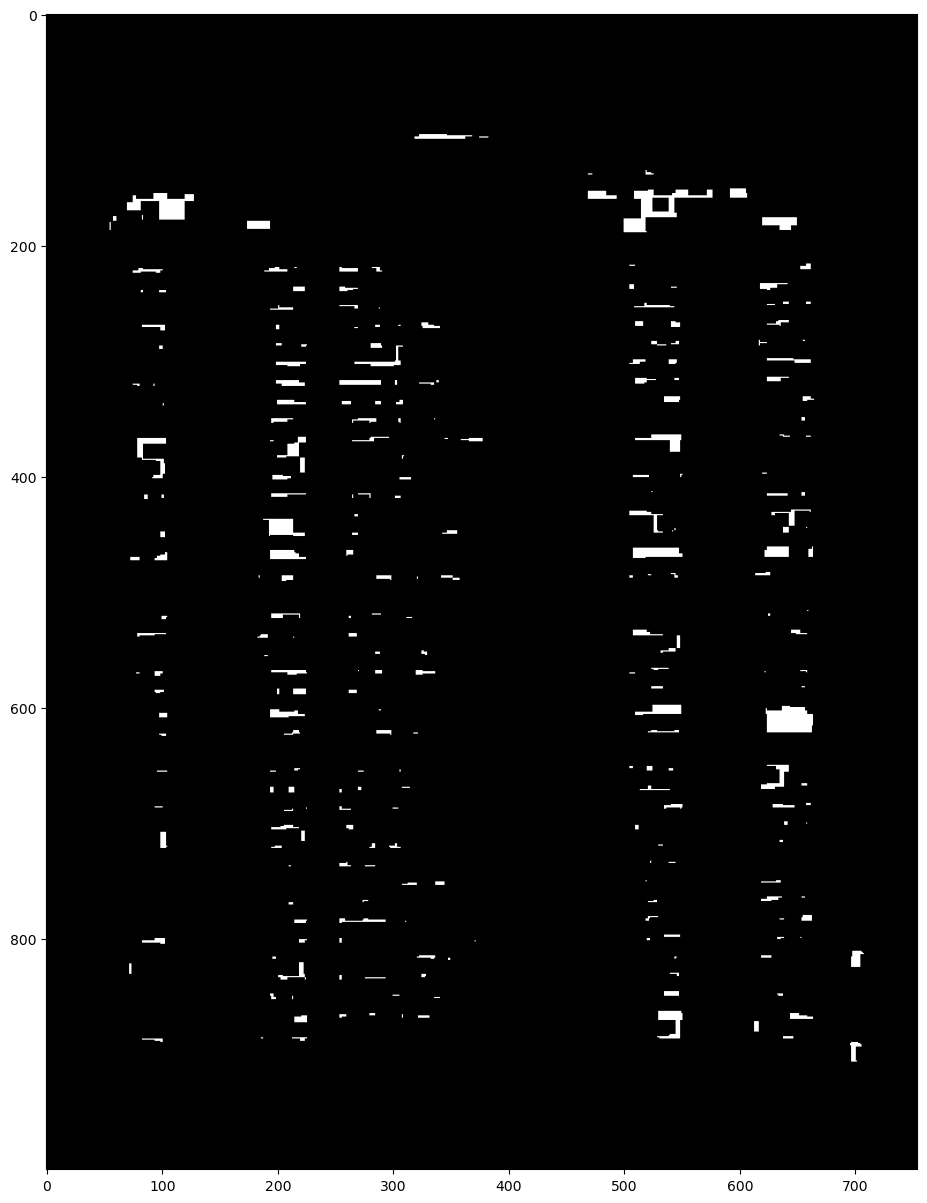

In [32]:
I=imread(dir_base_documentos+'/86652166_2168.tif')

fig, ax= plt.subplots(figsize=(15,15))

h,w=I.shape

#Se binariza la imagen con un threshold bajo para eliminar ruido
_, I_bin = cv2.threshold(I, 20, 255, cv2.THRESH_BINARY_INV)

#Utilizando una cerradura se busca unir todas las letras que forman una columna
kernel = np.ones((10,10), np.uint8)
closing = cv2.morphologyEx(I_bin, cv2.MORPH_CLOSE, kernel)

#Utilizando una erosion se busca eliminar todas las letras y lineas aisladas
kernel2 = np.ones((3,3), np.uint8)
I_morph = cv2.erode(closing, kernel2, iterations=1)

columnas_limpias=0
#Se detecta si hay perfiles verticales que no pasen por una de las "columnas" resultantes
for i in range(1,10):
        if np.sum(I_morph[:,i*w//10])==0:
            columnas_limpias+=1
            
print(columnas_limpias)

ax.imshow(I_morph, cmap='gray')

La idea de esta función generar regiones horizontales en los renglones aplicando operaciones morfológicas, luego detectar si en el documento hay perfiles verticales que no atraviesan ninguna de estas regiones, en ese caso se considera que allí hay una división entre columnas, por lo que el documento tiene texto en columnas. Esta implementación, al evaluar perfiles verticales, solo funcionaría con imágenes con orientación vertical, se podría hacer otra función para evaluar imágenes con orientación horizontal

Implementación

In [33]:
def tiene_texto_en_columnas(I_doc):
    """
    Determina si el documento tiene texto en columnas

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    tiene_columnas (bool): Verdadero en caso de tener columnas
    """

    # IMPLEMENTAR #
    
    h,w=I.shape

    #Se binariza la imagen con un threshold bajo para eliminar ruido
    _, I_bin = cv2.threshold(I, 20, 255, cv2.THRESH_BINARY_INV)

    #Utilizando un kernel grande para hacer la cerradura se busca unir todas las letras
    kernel = np.ones((10,10), np.uint8)
    closing = cv2.morphologyEx(I_bin, cv2.MORPH_CLOSE, kernel)
    
    #Con un erode se busca eliminar líneas aisladas
    kernel = np.ones((3,3), np.uint8)
    I_morph = cv2.erode(closing, kernel, iterations=1)
    
    columnas_limpias=0

    #Se traza 10 perfiles en la imágen y se detecta si cortan alguna línea de texto
    for i in range(1,11):
        if np.sum(I_morph[:,i*w//11])==0:
            columnas_limpias+=1
    
    #Si 2 o más columnas no contienen texto el texto está ordenado en columnas
    tiene_columnas = columnas_limpias >= 2
    
    return tiene_columnas

Tests sobre imágenes

In [34]:
resultado=[]
for filename in filenames:
    image_directory=os.path.join(dir_base_documentos, filename)
    I=imread(image_directory)
    resultado.append(tiene_texto_en_columnas(I))
    
print('Porcentaje de acierto en todo el conjunto: '+str(sum(gt['tiene_columnas']==resultado)/len(resultado)))
print('Porcentaje de acierto en imágenes con orientación vertical: '+str(sum((gt['tiene_columnas']==resultado)[gt['orientacion_vertical']==1]/sum(gt['orientacion_vertical']))))

Porcentaje de acierto en todo el conjunto: 0.5815602836879432
Porcentaje de acierto en imágenes con orientación vertical: 0.5755102040816329


F1 score en todo el conjunto de imágenes: 0.4869565217391304
F1 score en imágenes con orientación vertical: 0.4157303370786517


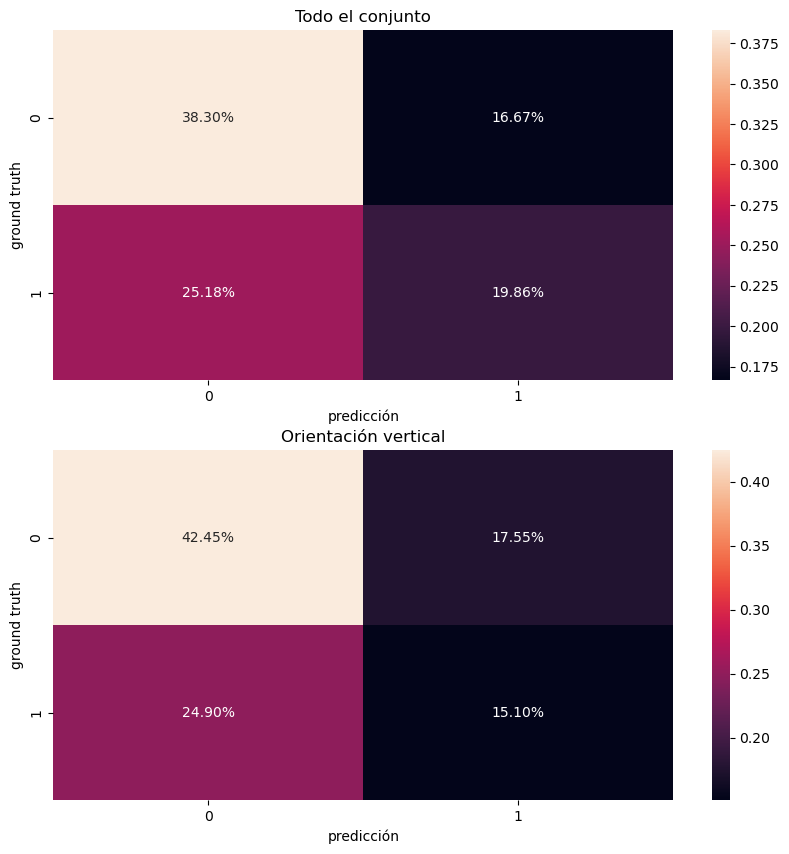

In [35]:
cf_matrix = confusion_matrix(gt['tiene_columnas'], resultado)
cf_matrix_2 = confusion_matrix(gt['tiene_columnas'][gt['orientacion_vertical']==1], np.array(resultado)[gt['orientacion_vertical']==1])

fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', ax=ax[0])
ax[0].set_xlabel('predicción')
ax[0].set_ylabel('ground truth')
ax[0].set_title('Todo el conjunto')

sns.heatmap(cf_matrix_2/np.sum(cf_matrix_2), annot=True, fmt='.2%', ax=ax[1])
ax[1].set_xlabel('predicción')
ax[1].set_ylabel('ground truth')
ax[1].set_title('Orientación vertical')

f1= f1_score(gt['tiene_columnas'], resultado)
f1_2= f1_score(gt['tiene_columnas'][gt['orientacion_vertical']==1], np.array(resultado)[gt['orientacion_vertical']==1])

print('F1 score en todo el conjunto de imágenes: '+str(f1))
print('F1 score en imágenes con orientación vertical: '+str(f1_2))

Se tiene un porcentaje de acierto de alrededor del 58% para todo el conjunto de imágenes, por más que la función está pensada para funcionar únicamente en imágenes con orientación vertical. El resultado en este conjunto de imágenes es símilar. Los errores pueden deberse a casos en los que los perfiles que se halla no están ubicados exactamente en el espacio entre columnas, resultando en un falso negativo, o están ubicados en un espacio que se generó a partir de las manipulaciones de la imagen pero no representa un espacio entre columnas, resultando en un falso positivo. A partir del F1 score se puede deducir que la función no tiene resultados satisfactorios, más teniendo en cuenta que tiene un desempeño peor en los documentos con orientación vertical, cuando en realidad se diseñó para funcionar exclusivamente en ellos.

##### 5.5 Límites horizontales

Discusión de métodos, pruebas

Implementación

In [36]:
def limites_horizontales(I_doc):
    """
    Devuelve una lista de valores con las columnas de inicio y fin del contenido del documento
    y, si contiene columnas, las posiciones horizontales que separan las columnas

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    limites (list): [inicio, fin] si el documento no contiene texto en columnas
                    [inicio, sep1,...,sepN, fin] si contiene columnas 
    """

    # IMPLEMENTAR #

    return limites

Tests sobre imágenes

##### 5.6 Alto de línea

Discusión de métodos, pruebas

Implementación

In [37]:
def alto_de_linea(I_doc):
    """
    Devuelve el alto de línea del documento

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    alto (int o double): Alto de la línea 
    """

    # IMPLEMENTAR #

    return alto

Tests sobre imágenes

##### 5.7 Ancho de letra

Discusión de métodos, pruebas

Implementación

In [38]:
def ancho_de_letra(I_doc):
    """
    Devuelve el ancho de letra del documento
    Se supone que la imagen pasada comprende un documento que, mayoritariamente,
    tiene tipo de letra "monospaced" 

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    ancho (int o double): ancho de letra 
    """

    # IMPLEMENTAR #

    return ancho

Tests sobre imágenes

##### 5.8 ¿El documento contiene figuras?

Discusión de métodos, pruebas

Area mínima: 
7660.0
Area de la región detectada como figura: 
7804.0
Densidad de la región: 
48.038698103536646
True


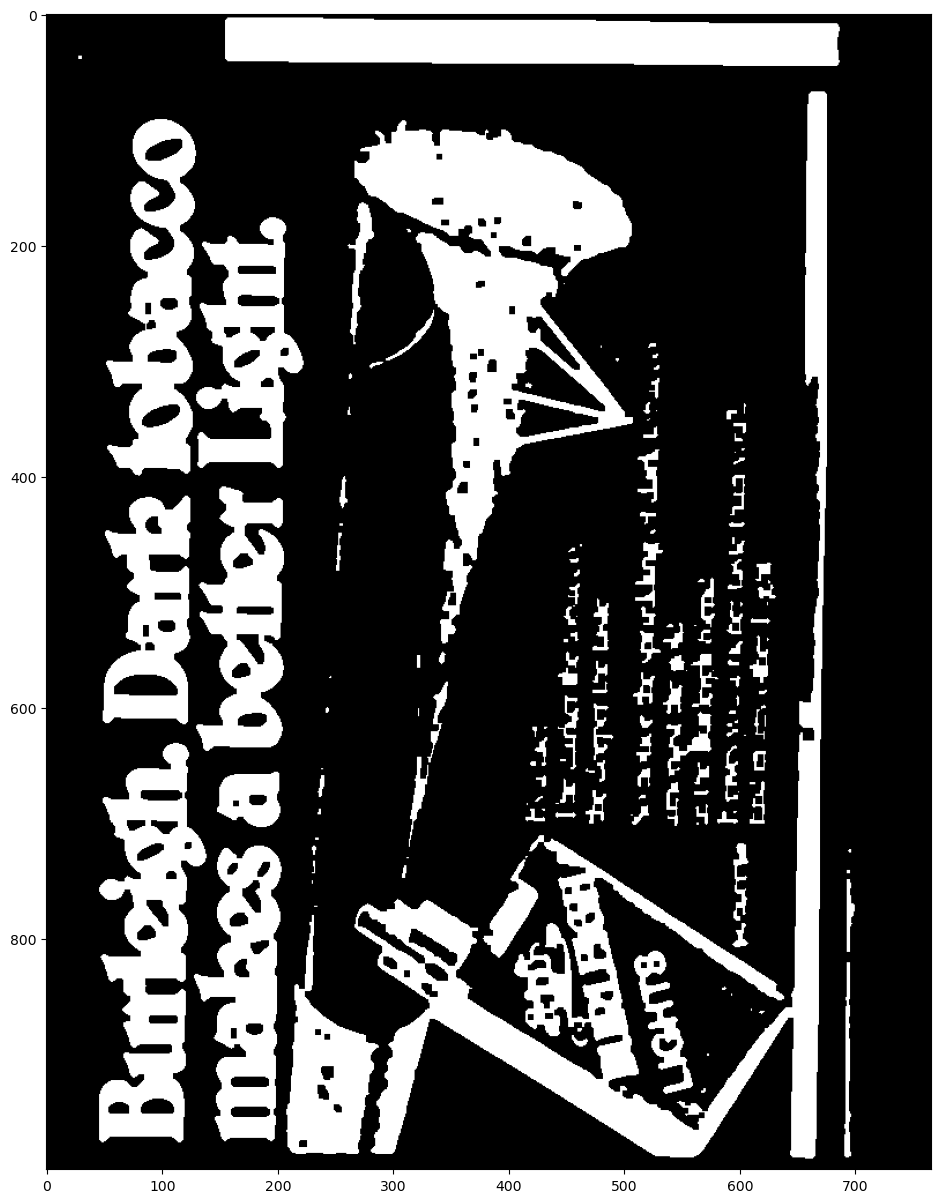

In [63]:
I=imread(dir_base_documentos+'/01339594.tif')

# Se aplica un filtro de mediana para reducir el ruido
I = cv2.medianBlur(I, 5)

# Luego se aplica un umbral para segmentar la imagen
_, thresh = cv2.threshold(I, 127, 255, cv2.THRESH_BINARY_INV)

# Se aplica una cerradura para cerrar los pequeños huecos en las regiones
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# Se detectan los contornos en la imagen
contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Se etiquetan las regiones y se verifica su tamaño
tiene_figura = False
area_minima = 0.01 * I.shape[0] * I.shape[1]  # 1% del total de la imagen
for contour in contours:
    # Se obtiene el área del contorno
    area = cv2.contourArea(contour)

    # Si el área es mayor al 1% de la imagen, se considera que hay una figura
    if area > area_minima:
        # Se calcula la densidad de la figura (suma de los valores de los píxeles / área)
        mask = np.zeros_like(I)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        densidad = cv2.sumElems(I & mask)[0] / area

        # Si la densidad no es uniforme, se considera que es una figura
        if densidad < 200 or densidad > 40:
            tiene_figura = True
            break
                
fig, ax= plt.subplots(figsize=(15,15))

ax.imshow(closing, cmap='gray')
print('Area mínima: ')
print(area_minima)
print('Area de la región detectada como figura: ')
print(area)
print('Densidad de la región: ')
print(densidad)
print(tiene_figura)

La implementación se basa en la idea de que una figura es una región conexa que ocupa al menos el 1% del área de la imagen. Además se tiene en cuenta que no sea una región densa de tono aproximadamente uniforme, para no detectar los bordes de escaneo de la página, que en muchos casos podrían ser detectados como figuras.

Implementación

In [64]:
def tiene_alguna_figura(I_doc):
    """
    Determina si el documento tiene alguna figura

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    tiene_figura (bool): Verdadero en caso de tener alguna figura
    """
    
    # Se aplica un filtro de mediana para reducir el ruido
    I_doc = cv2.medianBlur(I_doc, 5)

    # Luego se aplica un umbral para segmentar la imagen
    _, thresh = cv2.threshold(I_doc, 127, 255, cv2.THRESH_BINARY_INV)

    # Se aplica la operación de morfología para cerrar los pequeños huecos en las regiones
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Se detectan los contornos en la imagen
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Se etiquetan las regiones y se verifica su tamaño
    tiene_figura = False
    area_minima = 0.01 * I_doc.shape[0] * I_doc.shape[1]  # 1% del total de la imagen
    for contour in contours:
        # Se obtiene el área del contorno
        area = cv2.contourArea(contour)

        # Si el área es mayor al 1% de la imagen, se considera que hay una figura
        if area > area_minima:
            # Se calcula la densidad de la figura (suma de los valores de los píxeles / área)
            mask = np.zeros_like(I_doc)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            densidad = cv2.sumElems(I_doc & mask)[0] / area

            # Si la densidad no es uniforme, se considera que es una figura
            if densidad < 200 or densidad > 40:  # Los valores son arbitrarios y pueden ajustarse
                tiene_figura = True
                break

    return tiene_figura

Tests sobre imágenes

In [65]:
resultado=[]
for filename in filenames:
    image_directory=os.path.join(dir_base_documentos, filename)
    I=imread(image_directory)
    resultado.append(tiene_alguna_figura(I))
    
print('Porcentaje de acierto: ' + str(sum(gt['tiene_figura_ext']==resultado)/len(resultado)))

Porcentaje de acierto: 0.8652482269503546


F1 score: 0.736111111111111


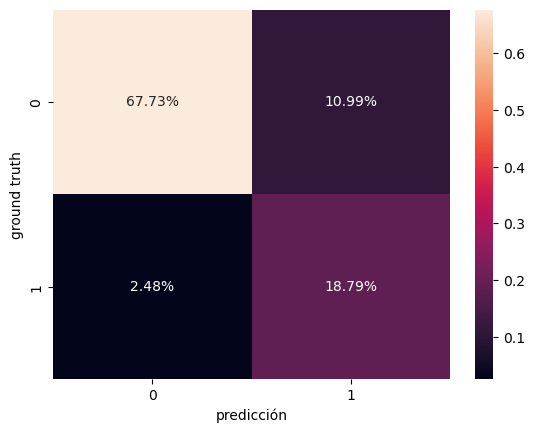

In [66]:
cf_matrix = confusion_matrix(gt['tiene_figura_ext'], resultado)
ax= sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')
ax.set_xlabel('predicción')
ax.set_ylabel('ground truth')

f1= f1_score(gt['tiene_figura_ext'], resultado)

print('F1 score: '+str(f1))

Se tiene un porcentaje de acierto del 87% y un F1 score relativamente alto. Viendo la matriz de confusión se puede apreciar que el porcentaje de casos mal clasificados es bajo tanto para los documentos con figuras como para los documentos sin figuras, por lo que se puede suponer que en otro conjunto de imágenes donde haya más documentos con figuras el porcentaje de acierto sería similar. Cabe mencionar que se podría realizar una mejor discriminación de las figuras para así poder comparar los resultados con la columna "tiene figura" del dataframe de ground truth, y así obtener resultados más similares a los que se obtendría si las imágenes fueran clasificadas por un humano. 

